# Math 610: Homework 2
**Neal Kuperman**


In [ ]:
#%% Packages
from ISLP import load_data, confusion_table

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns

import pandas as pd
import numpy as np
import statsmodels.api as smf

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (r2_score, mean_squared_error, accuracy_score, confusion_matrix,
                             roc_auc_score, classification_report, ConfusionMatrixDisplay, 
                             roc_curve, auc)
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

from IPython.display import display, HTML

RANDOM_STATE = 1
VERBOSE = True
PRINT_LATEX = False
SAVE_FIGS = True

## Problem 1: College Data Analysis

Consider the `College` data from the ISLP package. Details about the data is described on page 65 of the ISLP textbook for this class ([https://islp.readthedocs.io/en/latest/datasets/College.html](https://islp.readthedocs.io/en/latest/datasets/College.html)).

We would like to *predict* the **number of applications** received using the other variables.

80% of the data (randomly generated) will be treated as training data. The rest will be the test data.

---

**a)** Fit a linear model using least squares and report the estimate of the test error.

**b)** Fit a tree to the data. Summarize the results. Unless the number of terminal nodes is large, display the tree graphically. Report its MSE.

**c)** Use Cross validation to determine whether pruning is helpful and determine the optimal size for the pruned tree. Compare the pruned and un-pruned trees. Report MSE for the pruned tree. Which predictors seem to be the most important?

**d)** Use a bagging approach to analyze the data with B = 500 and B = 1000. Compute the MSE. Which predictors seem to be the most important?

**e)** Repeat (d) with a random forest approach with B = 500 and B = 1000, and m ≈ p = 3.

**f)** Compare the results from the various methods. Which method would you recommend?

In [86]:
college_original = load_data("College")

if VERBOSE:
    display(college_original.head())
    display(college_original.describe().round(3))

if PRINT_LATEX:
    desc = college_original.describe().round(3)

    # Number of columns per table
    cols_per_table = 6

    # Get all column names
    all_cols = desc.columns.tolist()

    # Split columns into chunks of 5
    for i in range(0, len(all_cols), cols_per_table):
        cols_chunk = all_cols[i:i+cols_per_table]
        desc_subset = desc[cols_chunk].style.format("{:.2f}")
        
        print(f"\n# Table {i//cols_per_table + 1}: Columns {i+1}-{min(i+cols_per_table, len(all_cols))}")
        print(desc_subset.to_latex())
        print("\n" + "="*80 + "\n")



,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
count,777.000,777.000,777.000,777.000,777.000,777.000,777.000,777.000,777.000,777.000,777.000,777.000,777.000,777.000,777.000,777.000,777.000
mean,3001.638,2018.804,779.973,27.559,55.797,3699.907,855.299,10440.669,4357.526,549.381,1340.642,72.660,79.703,14.090,22.744,9660.171,65.463
std,3870.201,2451.114,929.176,17.640,19.805,4850.421,1522.432,4023.016,1096.696,165.105,677.071,16.328,14.722,3.958,12.392,5221.768,17.178
min,81.000,72.000,35.000,1.000,9.000,139.000,1.000,2340.000,1780.000,96.000,250.000,8.000,24.000,2.500,0.000,3186.000,10.000
25%,776.000,604.000,242.000,15.000,41.000,992.000,95.000,7320.000,3597.000,470.000,850.000,62.000,71.000,11.500,13.000,6751.000,53.000
50%,1558.000,1110.000,434.000,23.000,54.000,1707.000,353.000,9990.000,4200.000,500.000,1200.000,75.000,82.000,13.600,21.000,8377.000,65.000
75%,3624.000,2424.000,902.000,35.000,69.000,4005.000,967.000,12925.000,5050.000,600.000,1700.000,85.000,92.000,16.500,31.000,10830.000,78.000
max,48094.000,26330.000,6392.000,96.000,100.000,31643.000,21836.000,21700.000,8124.000,2340.000,6800.000,103.000,100.000,39.800,64.000,56233.000,118.000


Before answering any of the questions, we need to process the data
1) split into 80/20 train/test split
2) Convert the Private variable to a numeric value using one-hot encoding or dummy in Pandas
3) Scale numeric independent variables using the standard scalar transform from scikit-learn 
4) Add intercept column to train and test dfs which is needed when passing a dataframe into statsmodel OLS function


In [87]:
y = college_original["Apps"]
X_original = college_original.drop(columns=["Apps"])
X_train_original, X_test_original, y_train, y_test = train_test_split(
    X_original, y, test_size=0.3, random_state=RANDOM_STATE
)

#============================
# One-hot encoding code
#============================
num_cols = X_original.select_dtypes(include=['number']).columns
cat_cols = X_original.select_dtypes(include=['category']).columns
transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(sparse_output=False, drop='first'), cat_cols),
    ],
    remainder="passthrough" 
)


X_train_transformed = transformer.fit_transform(X_train_original)
X_test_transformed = transformer.transform(X_test_original)
feature_names = [name.split("__", 1)[1] for name in transformer.get_feature_names_out()]
X_train = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test = pd.DataFrame(X_test_transformed, columns=feature_names)
X_train.insert(0, 'Intercept', 1.0)
X_test.insert(0, 'Intercept', 1.0)

if VERBOSE:
    display(X_train.head())


,Intercept,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private_Yes
0,1.0,-0.058196,-0.118492,-0.225659,0.024979,-0.217425,-0.104390,0.121919,-0.085814,-0.298397,0.052577,-1.622940,-2.069873,-0.187624,-0.406739,-0.375132,-0.035896,1.0
1,1.0,-0.426920,-0.476790,-0.501014,-0.075122,-0.493624,-0.067061,0.429505,-0.453002,-0.419558,-0.620503,0.057778,0.055583,0.958236,0.176223,-0.383291,0.771435,1.0
2,1.0,0.302084,-0.117393,-0.996653,-1.826882,-0.337745,0.543182,0.509528,1.538992,-0.298397,-0.919650,-1.809686,-1.857328,0.601746,-1.239542,-0.330531,-0.266561,1.0
3,1.0,0.340685,0.801434,-0.776369,-0.425474,0.830932,0.529386,-0.902367,-1.817104,-0.189351,0.815400,-0.004471,-0.156963,1.314725,-0.739860,-0.703296,-0.554894,0.0
4,1.0,-0.625556,-0.705398,0.104767,0.925884,-0.641647,-0.583170,0.079408,0.061061,0.125669,0.254500,-1.124949,-1.432236,-0.238551,-0.823140,-0.247493,-0.612560,1.0


**a)** Fit a Linear Model using least squares and report the estimate of the test error.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     370.2
Date:                Wed, 04 Feb 2026   Prob (F-statistic):          3.18e-279
Time:                        13:08:30   Log-Likelihood:                -4582.2
No. Observations:                 543   AIC:                             9200.
Df Residuals:                     525   BIC:                             9278.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3367.3648    144.649     23.280      

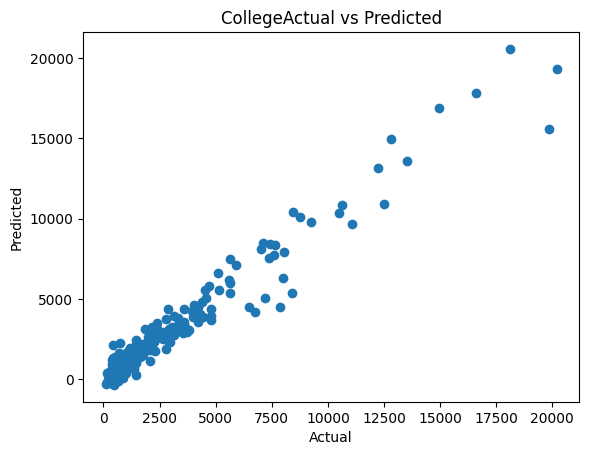

In [88]:
# Linear model and error report
model = smf.OLS(y_train.values, X_train).fit()


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
mse_train = mean_squared_error(y_train.values, y_train_pred)
mse_test = mean_squared_error(y_test.values, y_test_pred)
r2_train = r2_score(y_train.values, y_train_pred)
r2_test = r2_score(y_test.values, y_test_pred)

if VERBOSE:
    print(model.summary())

    print(f"Train MSE: {mse_train}")
    print(f"Train R2: {r2_train}")
    print(f"\n\nTest MSE: {mse_test}")
    print(f"Test R2: {r2_test}")


    plt.plot(y_test.values, y_test_pred, 'o')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('CollegeActual vs Predicted')
    plt.show()

if PRINT_LATEX:
    print(model.summary().as_latex())



**b)** Fit a *regression* tree to the data. Summarize the results. Unless the number of terminal nodes is large, display the tree graphically. Report its MSE.



Tree w/ max depth = 3


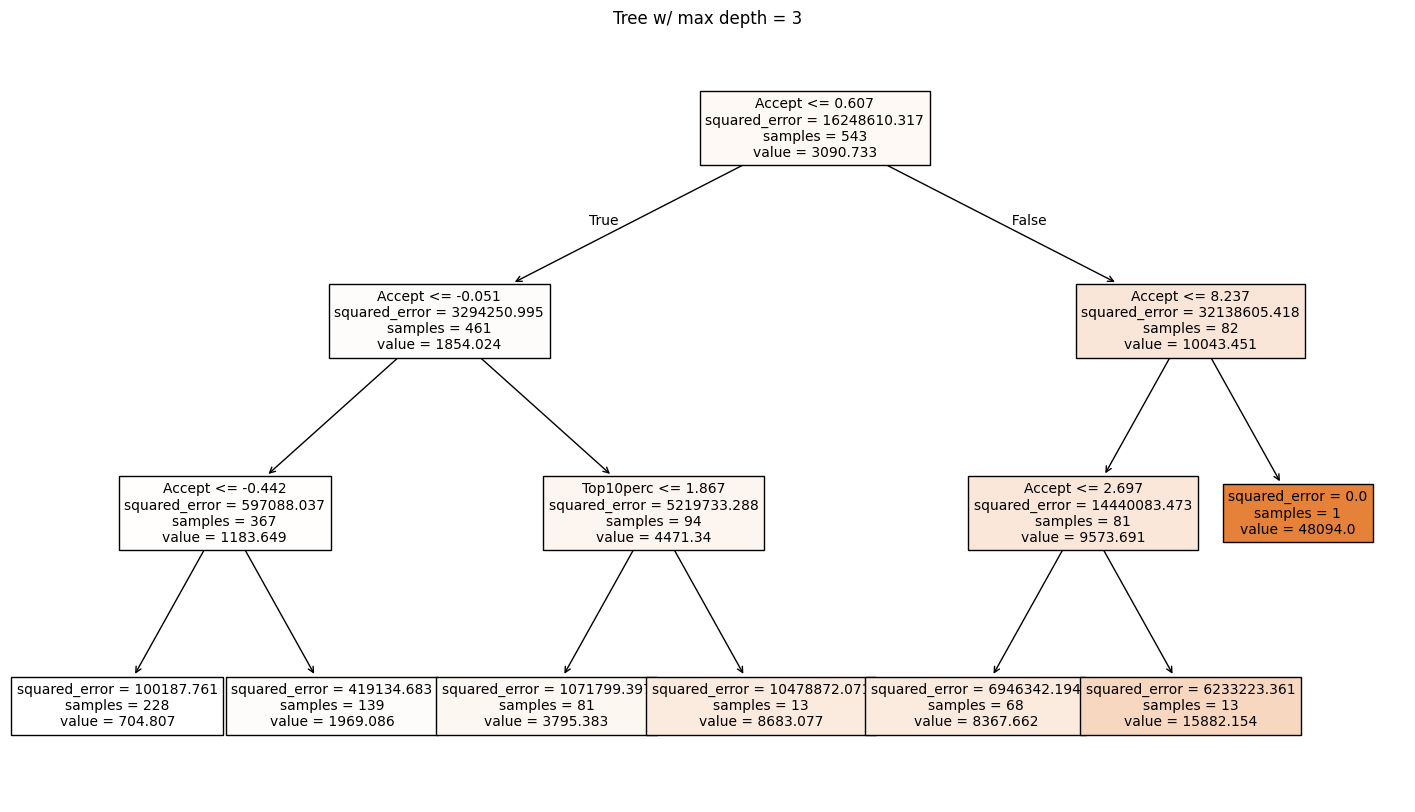

training MSE: 1579239.026601429
training R2: 0.9028077481233885
test MSE: 1951789.186151359
test R2: 0.8360651654030796


Tree w/ max depth = 10
training MSE: 9582.208465262604
training R2: 0.9994102752002689
test MSE: 1069906.932838315
test R2: 0.9101362906847533


Tree w/ max depth = None
training MSE: 0.0
training R2: 1.0
test MSE: 1082956.5683760685
test R2: 0.9090402246451366


Accept         0.966403
Top10perc      0.033597
Intercept      0.000000
Personal       0.000000
Grad.Rate      0.000000
Expend         0.000000
perc.alumni    0.000000
S.F.Ratio      0.000000
Terminal       0.000000
PhD            0.000000
dtype: float64

Accept         0.910615
Top10perc      0.038446
Top25perc      0.016548
F.Undergrad    0.015113
Outstate       0.003668
Expend         0.002848
PhD            0.002825
Grad.Rate      0.002648
S.F.Ratio      0.002398
Books          0.001412
dtype: float64

Accept         0.910207
Top10perc      0.038643
Top25perc      0.016027
F.Undergrad    0.009648
Outstate       0.005583
Expend         0.004808
Personal       0.003827
PhD            0.002809
S.F.Ratio      0.002484
Books          0.001928
dtype: float64

In [89]:
def fit_and_plot_tree(X_train, y_train, X_test, y_test, max_depth, save_fig=False):
    tree = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_STATE, criterion="squared_error")
    tree.fit(X_train, y_train)
    y_pred_tree = tree.predict(X_test)
    y_pred_train = tree.predict(X_train)
    train_mse_tree = mean_squared_error(y_train, y_pred_train)
    train_r2_tree = r2_score(y_train, y_pred_train)
    test_mse_tree = mean_squared_error(y_test, y_pred_tree)
    test_r2_tree = r2_score(y_test, y_pred_tree)

    if VERBOSE:
        print("\n")
        print(f"Tree w/ max depth = {max_depth}")
        print("="*60)   

        if max_depth is not None and max_depth < 5:
            fig, ax = plt.subplots(figsize=(18, 10))
            plot_tree(tree, max_depth=max_depth, feature_names=pd.get_dummies(X_train).columns, ax=ax, fontsize=10, filled=True)
            ax.set_title(f"Tree w/ max depth = {max_depth}")
            if save_fig and SAVE_FIGS:
                plt.savefig(f"../images/HW_2/prob_1_tree_max_depth_{max_depth}.png", dpi=300)
            plt.show()

        print(f"training MSE: {train_mse_tree}")
        print(f"training R2: {train_r2_tree}")
        print(f"test MSE: {test_mse_tree}")
        print(f"test R2: {test_r2_tree}")
        print("="*60)

    return tree

tree_depth_3 = fit_and_plot_tree(X_train, y_train, X_test, y_test, 3)
tree_depth_10 = fit_and_plot_tree(X_train, y_train, X_test, y_test, 10)
tree_depth_none = fit_and_plot_tree(X_train, y_train, X_test, y_test, None)

importances_3 = pd.Series(
    tree_depth_3.feature_importances_,
    index=pd.get_dummies(X_train).columns
).sort_values(ascending=False)

importances_10 = pd.Series(
    tree_depth_10.feature_importances_,
    index=pd.get_dummies(X_train).columns
).sort_values(ascending=False)

importances_none = pd.Series(
    tree_depth_none.feature_importances_,
    index=pd.get_dummies(X_train).columns
).sort_values(ascending=False)

if VERBOSE:
    display(importances_3.head(10))
    display(importances_10.head(10))
    display(importances_none.head(10))


Three initial regression trees were created with maximum depths of 3, 10, and unrestricted. Setting max_depth=None allows the algorithm to expand nodes until all leaves are pure or contain fewer than min_samples_split samples. The unrestricted tree reached a depth of 20 with 537 leaves.

**c)** Use Cross validation to determine whether pruning is helpful and determine the optimal size for the pruned tree. Compare the pruned and un-pruned trees. Report MSE for the pruned tree. Which predictors seem to be the most important?

We will use the `cost_complexity_pruning_path()` method of the `DecisionTreeRegressor` class to extract cost-complexity values. We will use the tree with a max depth of 10 to see how much reduction in complexity the pruning can achieve

In [90]:
path = tree_depth_none.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas

kfold = KFold(10,
              random_state=RANDOM_STATE,
              shuffle=True)

grid = GridSearchCV(DecisionTreeRegressor(random_state=RANDOM_STATE, criterion="squared_error"),
                        {'ccp_alpha': alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

best_alpha = grid.best_params_["ccp_alpha"]
best_cv_mse = -grid.best_score_

if VERBOSE:
    print(f"Best alpha: {best_alpha}")
    print(f"Best CV MSE: {best_cv_mse}")
    # print(f"Best Score: {grid.best_score_}")

Best alpha: 17157.520202020256
Best CV MSE: 3062403.669982943


Best Tree Training MSE: 332673.17082394497
Best Tree Training R2: 0.9795260539622719
Best Tree Test MSE: 873227.4705536155
Best Tree Test R2: 0.9266558079292521
Best Tree Leaves: 22
Best Tree Depth: 7
Best Tree R2: 0.9266558079292521


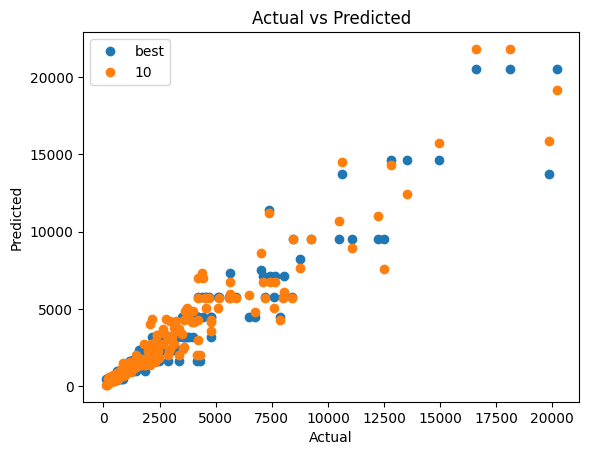

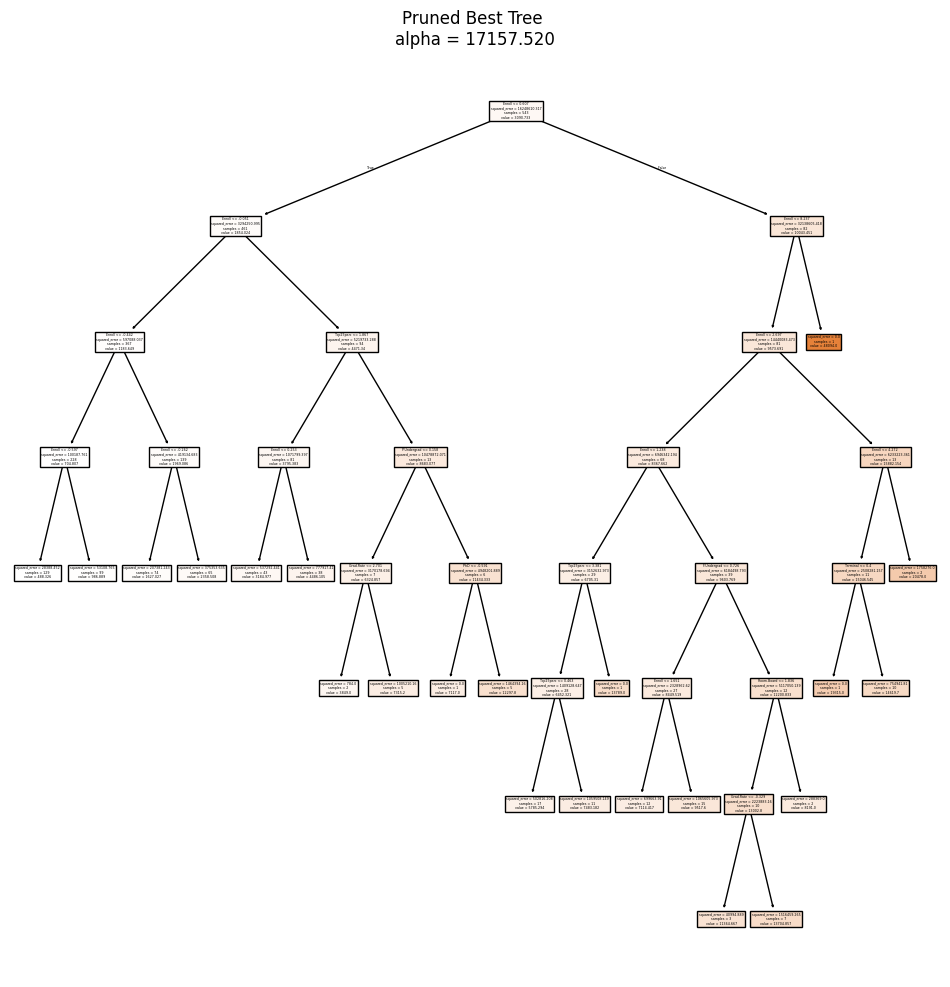

In [91]:
best_tree = grid.best_estimator_

y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)  
test_r2 = r2_score(y_test, y_test_pred)

if VERBOSE:
    print(f"Best Tree Training MSE: {train_mse}")
    print(f"Best Tree Training R2: {train_r2}")
    print(f"Best Tree Test MSE: {test_mse}")
    print(f"Best Tree Test R2: {test_r2}")
    print(f"Best Tree Leaves: {best_tree.get_n_leaves()}")
    print(f"Best Tree Depth: {best_tree.get_depth()}")
    print(f"Best Tree R2: {r2_score(y_test, y_test_pred)}")

    plt.plot(y_test.values, y_test_pred, 'o', label='best')
    plt.plot(y_test.values, tree_depth_10.predict(X_test), 'o', label = "10")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.show()

    ax = subplots(figsize=(12, 12))[1]
    plot_tree(best_tree,
            feature_names=feature_names,
            ax=ax,
            filled=True);
    plt.title(f'Pruned Best Tree \nalpha = {best_alpha:.3f}')
    if SAVE_FIGS:
        plt.savefig(f'../images/HW_2/pruned_best_tree_alpha_{best_alpha:.3f}.png', dpi=300)
    plt.show()


In [92]:
importances = pd.Series(
    best_tree.feature_importances_,
    index=pd.get_dummies(X_train).columns
).sort_values(ascending=False)

if VERBOSE:
    print(importances.head(10))
if PRINT_LATEX:
    print(importances.to_latex())

Accept         0.924818
Top10perc      0.039207
Top25perc      0.013527
F.Undergrad    0.009759
Outstate       0.004465
Expend         0.003317
Personal       0.002588
PhD            0.002319
Intercept      0.000000
S.F.Ratio      0.000000
dtype: float64


**d)** Use a bagging approach to analyze the data with B = 500 and B = 1000. Compute the MSE. Which predictors seem to be the most important?


Bagging 500 Training MSE: 351729.9477677717
Bagging 500 Training R2: 0.9783532289285171
Bagging 500 Test MSE: 655166.1253320684
Bagging 500 Test R2: 0.9449712340083184
Bagging 1000 Training MSE: 325604.622291094
Bagging 1000 Training R2: 0.9799610787671524
Bagging 1000 Test MSE: 652137.7751715085
Bagging 1000 Test R2: 0.9452255914390263


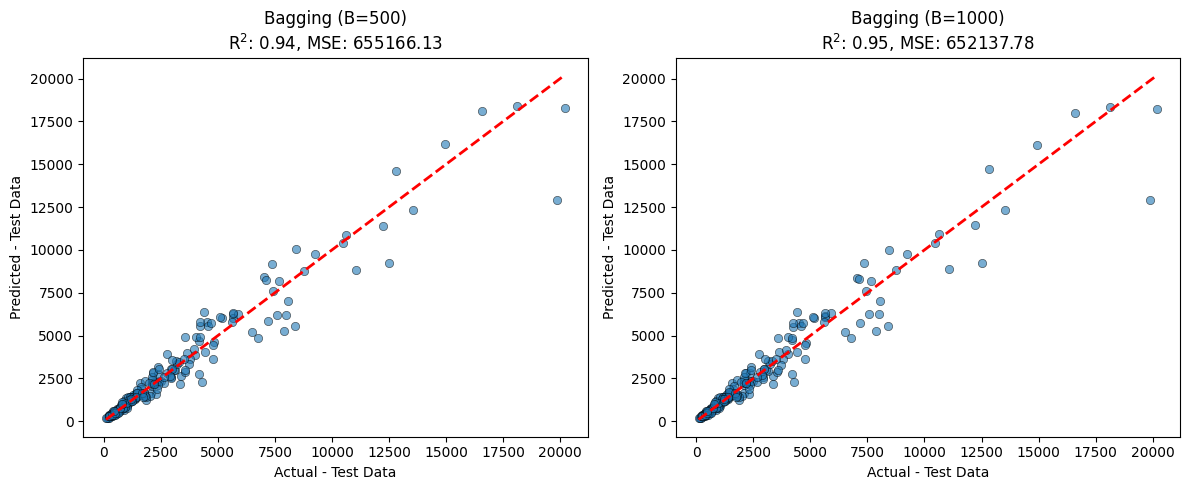

In [93]:
def bagging_regressor(X_train, y_train, X_test, y_test, n_estimators, save_fig=False):
    
    regressors = []
    
    if VERBOSE:
        fig, axes = plt.subplots(1, len(n_estimators), figsize=(12, 5))

    for i, n in enumerate(n_estimators):
        bag_n = BaggingRegressor(
            estimator=DecisionTreeRegressor(),
            n_estimators=n,
            random_state=RANDOM_STATE
        )

        regressors.append(bag_n)
        bag_n.fit(X_train, y_train)

        if VERBOSE:
            y_train_pred_n = bag_n.predict(X_train)     
            y_test_pred_n = bag_n.predict(X_test)
            train_mse_bag_n = mean_squared_error(y_train, y_train_pred_n)
            train_r2_bag_n = r2_score(y_train, y_train_pred_n)
            test_mse_bag_n = mean_squared_error(y_test, y_test_pred_n)
            test_r2_bag_n = r2_score(y_test, y_test_pred_n)
            print(f"Bagging {n} Training MSE: {train_mse_bag_n}")
            print(f"Bagging {n} Training R2: {train_r2_bag_n}")
            print(f"Bagging {n} Test MSE: {test_mse_bag_n}")
            print(f"Bagging {n} Test R2: {test_r2_bag_n}")

            axes[i].scatter(y_test, y_test_pred_n, alpha=0.6, edgecolors='k', linewidths=0.5)
            axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
            axes[i].set_xlabel('Actual - Test Data')
            axes[i].set_ylabel('Predicted - Test Data')
            axes[i].set_title(f'Bagging (B={n})\nR$^2$: {r2_score(y_test, y_test_pred_n):.2f}, MSE: {mean_squared_error(y_test, y_test_pred_n):.2f}') 

    if VERBOSE:
        plt.tight_layout()

    if save_fig and VERBOSE:
        estimator_names = str.join("_", [f"B={n}" for n in n_estimators])
        if SAVE_FIGS:
            plt.savefig(f'../images/HW_2/bagging_regressor_n_{estimator_names}.png', dpi=300)

    if VERBOSE:
        plt.show()

    return regressors

regressors = bagging_regressor(X_train, y_train, X_test, y_test, [500, 1000], save_fig=True)
bag_500, bag_1000 = regressors[0], regressors[1]




In [94]:
def print_feature_importance(regressor):
    imp = np.mean([
        tree.feature_importances_
        for tree in regressor.estimators_
    ], axis=0)
    display(pd.Series(imp, index=pd.get_dummies(X_train).columns)\
      .sort_values(ascending=False)\
      .head(10))

if VERBOSE:
    print("Feature Importance for Bagging (B=500)")
    print("="*60)
    print_feature_importance(bag_500)

    print("\n")
    print("Feature Importance for Bagging (B=1000)")
    print("="*60)
    print_feature_importance(bag_1000)

Feature Importance for Bagging (B=500)


Accept         0.802421
Enroll         0.103269
Top10perc      0.023217
Top25perc      0.017734
Expend         0.009980
Grad.Rate      0.008378
F.Undergrad    0.005095
S.F.Ratio      0.004847
perc.alumni    0.004394
Outstate       0.004204
dtype: float64



Feature Importance for Bagging (B=1000)


Accept         0.798977
Enroll         0.108115
Top10perc      0.022769
Top25perc      0.018266
Expend         0.008796
Grad.Rate      0.008535
F.Undergrad    0.005027
S.F.Ratio      0.004975
perc.alumni    0.004345
Outstate       0.004221
dtype: float64

**e)** Repeat (d) with a random forest approach with B = 500 and B = 1000, and m ≈ p = 3.


RF w 500 estimators Training MSE: 418695.3689692889
RF w 500 estimators Training R2: 0.974231927482182
RF w 500 estimators Test MSE: 1055332.128676855
RF w 500 estimators Test R2: 0.9113604588103094
RF w 1000 estimators Training MSE: 386329.4508083388
RF w 1000 estimators Training R2: 0.9762238466388954
RF w 1000 estimators Test MSE: 1086990.943392902
RF w 1000 estimators Test R2: 0.9087013690936359


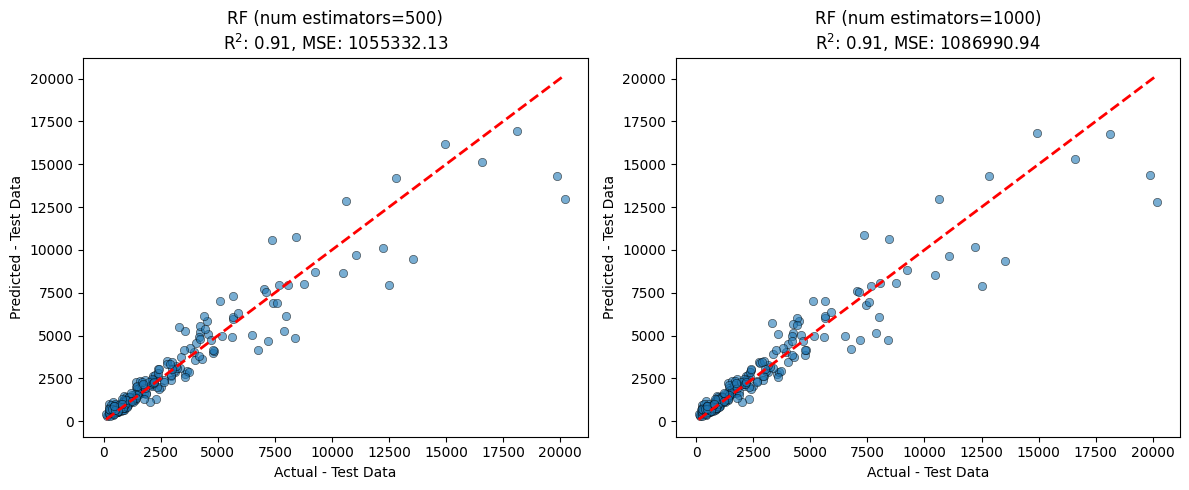

In [95]:
def RF_regressor(X_train, y_train, X_test, y_test, n_estimators, save_fig=False):
    
    regressors = []
    
    if VERBOSE:
        fig, axes = plt.subplots(1, len(n_estimators), figsize=(12, 5))

    for i, n in enumerate(n_estimators):
        RF_n = RandomForestRegressor(
            n_estimators=n,
            max_features=3,
            random_state=RANDOM_STATE
        )

        regressors.append(RF_n)

        RF_n.fit(pd.get_dummies(X_train), y_train)

        if VERBOSE:
            y_train_pred_n = RF_n.predict(pd.get_dummies(X_train))     
            y_test_pred_n = RF_n.predict(pd.get_dummies(X_test))
            train_mse_RF_n = mean_squared_error(y_train, y_train_pred_n)
            train_r2_RF_n = r2_score(y_train, y_train_pred_n)
            test_mse_RF_n = mean_squared_error(y_test, y_test_pred_n)
            test_r2_RF_n = r2_score(y_test, y_test_pred_n)
            print(f"RF w {n} estimators Training MSE: {train_mse_RF_n}")
            print(f"RF w {n} estimators Training R2: {train_r2_RF_n}")
            print(f"RF w {n} estimators Test MSE: {test_mse_RF_n}")
            print(f"RF w {n} estimators Test R2: {test_r2_RF_n}")

            axes[i].scatter(y_test, y_test_pred_n, alpha=0.6, edgecolors='k', linewidths=0.5)
            axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
            axes[i].set_xlabel('Actual - Test Data')
            axes[i].set_ylabel('Predicted - Test Data')
            axes[i].set_title(f'RF (num estimators={n})\nR$^2$: {r2_score(y_test, y_test_pred_n):.2f}, MSE: {mean_squared_error(y_test, y_test_pred_n):.2f}') 

    if VERBOSE:
        plt.tight_layout()

    if save_fig:
        estimator_names = str.join("_", [f"estimators={n}" for n in n_estimators])
        if SAVE_FIGS:
            plt.savefig(f'../images/HW_2/RF_regressor_n_{estimator_names}.png', dpi=300)

    if VERBOSE:
        plt.show()


    return regressors
    
regressors = RF_regressor(X_train, y_train, X_test, y_test, [500, 1000], save_fig=False)
RF_500, RF_1000 = regressors[0], regressors[1]


    

In [96]:
def print_feature_importance(regressor):
    imp = np.mean([
        tree.feature_importances_
        for tree in regressor.estimators_
    ], axis=0)
    display(pd.Series(imp, index=pd.get_dummies(X_train).columns)\
      .sort_values(ascending=False)\
      .head(10))

if VERBOSE:
    print("Feature Importance for Bagging (B=500)")
    print("="*60)
    print_feature_importance(RF_500)

    print("\n")
    print("Feature Importance for Bagging (B=1000)")
    print("="*60)
    print_feature_importance(RF_1000)

Feature Importance for Bagging (B=500)


Accept         0.259394
Enroll         0.194531
F.Undergrad    0.152924
P.Undergrad    0.055010
Top25perc      0.043281
PhD            0.038476
Top10perc      0.036371
Private_Yes    0.031446
Expend         0.029643
Terminal       0.027510
dtype: float64



Feature Importance for Bagging (B=1000)


Accept         0.252276
Enroll         0.193074
F.Undergrad    0.161521
P.Undergrad    0.050646
Top25perc      0.045768
Top10perc      0.039110
PhD            0.035762
Private_Yes    0.031904
Expend         0.029108
Terminal       0.028647
dtype: float64

**f)** Compare the results from the various methods. Which method would you recommend?

I would recommend the random forest with bagging classifier. Although the linear regression model has a similar MSE for the test data, the random forest will work with non-linear relationships making it a more robust classifier. The major benefit to the linear regression model is the interpretability of the coefficients.

## Problem 2: College Data Analysis

Consider the business school admission data available in the admission.csv. The admission officer of a business school has used an *“index”* of undergraduate grade point average (GPA,𝑋1) and graduate management aptitude test (GMAT,𝑋2) scores to help decide which applicants should be admitted to the school’s graduate programs. This index is used to categorize each applicant into one of three groups – admit (group 1), do not admit (group 2), and borderline (group 3). We will take the last ***four*** observations in **<u>each category</u>** as test data and the remaining observations as training data.



**a)** Perform an exploratory analysis of the training data by examining appropriate plots and comment on how helpful these predictors may be in predicting response.

**b)** Perform an LDA using the training data. Superimpose the decision boundary on an appropriate display of the data. Does the decision boundary seem sensible? In addition, compute the confusion matrix and overall misclassification rate based on both training and test data. What do you observe?

**c)** Repeat (b) using QDA.

**d)** Fit a KNN with K chosen optimally using test error rate. Report error rate, sensitivity, specificity, and AUC for the optimal KNN based on the training data. Also, report its estimated test error rate.

**e)** Compare the results in (b), (c) and (d). Which classifier would you recommend? Justify your conclusions.

---

In [97]:
# Problem 2 Helper Functions

def calculate_metrics(pos_cls, y_train, y_train_pred):
    # Confusion matrix for training
    y_binary = (y_train == pos_cls).astype(int)
    pred_binary = (y_train_pred == pos_cls).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_binary, pred_binary).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0    

    return sensitivity, specificity

def plot_roc_curve(classifier, y_train, X_train, save_fig=False, save_name = ""):
    # Binarize labels for multiclass
    y_train_bin = label_binarize(y_train, classes=classifier.classes_)
    y_train_pred_prob = classifier.predict_proba(X_train)

    # Plot ROC for each class
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classifier.classes_):
        fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_train_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Group {cls} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance level')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves: Multiclass (One-vs-Rest)\n' + save_name)
    plt.legend() 
    
    if save_fig and save_name != "":
        plt.savefig(f'../images/HW_2/{save_name}_roc_curve.png', dpi=300)
    plt.show()

    auc_train = roc_auc_score(y_train, y_train_pred_prob, multi_class="ovr", average="macro")
    name = save_name if save_name != "" else classifier.__class__.__name__
    print(f"{name} train AUC (macro OVR):", auc_train)


</br>
</br>

**a)** Perform an exploratory analysis of the training data by examining appropriate plots and comment on how helpful these predictors may be in predicting response.


In [98]:
admin_data = pd.read_csv("admission.csv")

if VERBOSE:
    display(HTML('<h3>Head of Admission Data</h3>'))
    display(admin_data.head())
    display(HTML('<h3>Description of Admission Data</h3>'))
    display(admin_data.describe())
    # print(admin_data.describe().to_latex())

    # Check for missing values
    display(HTML('<h3>Missing Values in Admission Data</h3>'))
    display(admin_data.isnull().sum())

# Split the data into training and test sets
train_data = admin_data[admin_data.groupby('Group').cumcount(ascending=False) >= 4]
test_data = admin_data.groupby('Group').tail(4)
# train_data = admin_data.iloc[:-4]
# test_data = admin_data.iloc[-4:]
y = admin_data['Group']
y_train = train_data['Group']
y_test = test_data['Group']
X = admin_data[['GPA', 'GMAT']]
X_train = train_data[['GPA', 'GMAT']]
X_test = test_data[['GPA', 'GMAT']]

# display(HTML(admin_data.to_html(max_rows=None)))

,GPA,GMAT,De,Group
0,2.96,596,admit,1
1,3.14,473,admit,1
2,3.22,482,admit,1
3,3.29,527,admit,1
4,3.69,505,admit,1


,GPA,GMAT,Group
count,85.000000,85.000000,85.000000
mean,2.974588,488.447059,1.941176
std,0.428995,81.522347,0.821626
min,2.130000,313.000000,1.000000
25%,2.600000,425.000000,1.000000
50%,3.010000,482.000000,2.000000
75%,3.300000,538.000000,3.000000
max,3.800000,693.000000,3.000000


GPA      0
GMAT     0
De       0
Group    0
dtype: int64

Missing values in adminission data:
GPA      0
GMAT     0
De       0
Group    0
dtype: int64


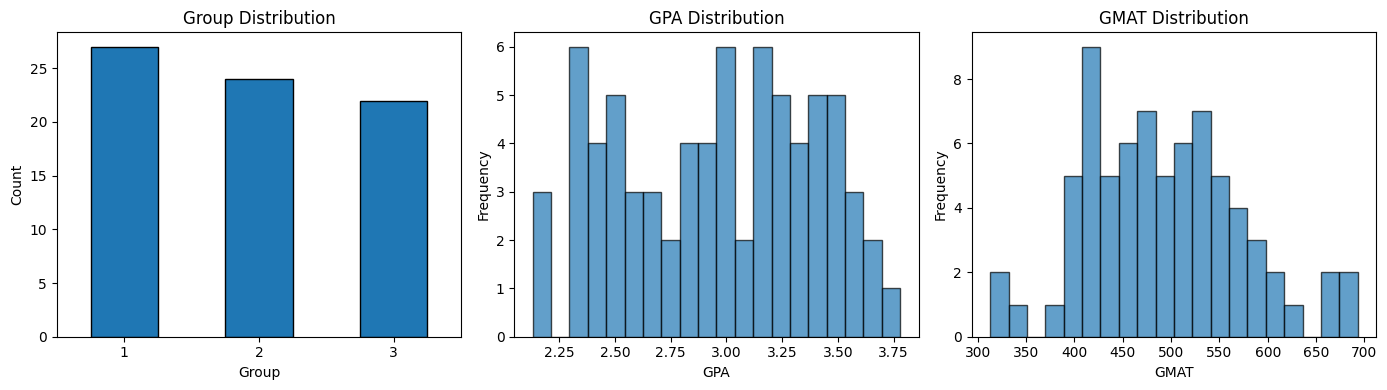

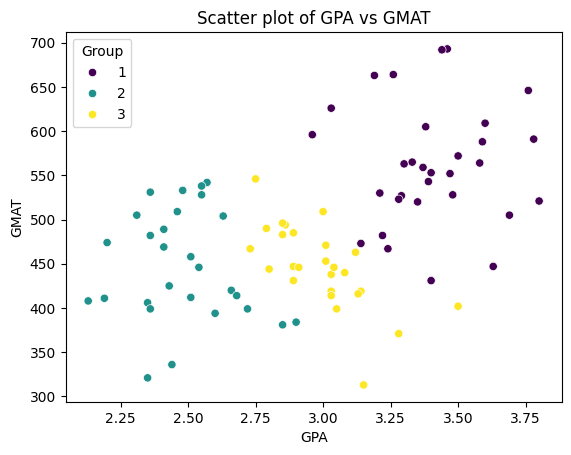

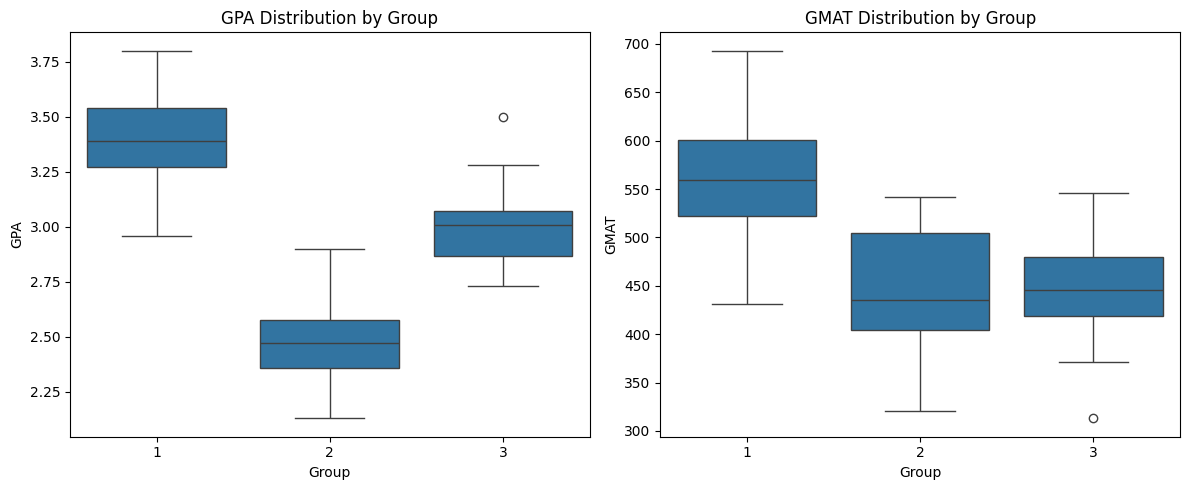

In [99]:
#EDA

if VERBOSE:
    # Check for missing values
    missing_values = admin_data.isnull().sum()
    print("Missing values in adminission data:")
    print(missing_values)

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # Bar plot of Group counts
    train_data['Group'].value_counts().plot(kind='bar', ax=axes[0], edgecolor='k')
    axes[0].set_title('Group Distribution')
    axes[0].set_xlabel('Group')
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=0)

    # Histogram for GPA
    axes[1].hist(train_data['GPA'], bins=20, edgecolor='k', alpha=0.7)
    axes[1].set_title('GPA Distribution')
    axes[1].set_xlabel('GPA')
    axes[1].set_ylabel('Frequency')

    # Histogram for GMAT
    axes[2].hist(train_data['GMAT'], bins=20, edgecolor='k', alpha=0.7)
    axes[2].set_title('GMAT Distribution')
    axes[2].set_xlabel('GMAT')
    axes[2].set_ylabel('Frequency')

    plt.tight_layout()
    if SAVE_FIGS:   
        plt.savefig('../images/HW_2/admission_data_EDA_histograms.png', dpi=300)
    plt.show()

    sns.scatterplot(data=admin_data, x='GPA', y='GMAT', hue='Group', palette='viridis')
    plt.title('Scatter plot of GPA vs GMAT')
    if SAVE_FIGS:
        plt.savefig('../images/HW_2/admission_data_EDA_scatterplot.png', dpi=300)
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.boxplot(data=admin_data, x='Group', y='GPA', ax=axes[0])
    axes[0].set_title('GPA Distribution by Group')

    sns.boxplot(data=admin_data, x='Group', y='GMAT', ax=axes[1])
    axes[1].set_title('GMAT Distribution by Group')

    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig('../images/HW_2/admission_data_EDA_boxplots.png', dpi=300)
    plt.show()


**comment on how helpful these predictors may be in predicting response.**

**b)** Perform an LDA using the training data. Superimpose the decision boundary on an appropriate display of the data. Does the decision boundary seem sensible? In addition, compute the confusion matrix and overall misclassification rate based on both training and test data. What do you observe?


In [100]:
# Apply Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(X_train, y_train)
y_pred_test = lda.predict(X_test)
y_pred_train = lda.predict(X_train)

lda.classes_

for i, _cls in enumerate(lda.classes_):   
    lda_training_sensitivity, lda_training_specificity = calculate_metrics(_cls, y_train, y_pred_train)
    lda_test_sensitivity, lda_test_specificity = calculate_metrics(_cls, y_test, y_pred_test)
    if VERBOSE:
        print(f"LDA Training: Class {_cls}: Sensitivity={lda_training_sensitivity:.4f}, Specificity={lda_training_specificity:.4f}")
        print(f"LDA Test: Class {_cls}: Sensitivity={lda_test_sensitivity:.4f}, Specificity={lda_test_specificity:.4f}")

if VERBOSE:
    display(HTML('<h3>Confusion Matrix for Training Data</h3>'))
    display(confusion_table(y_pred_train, y_train.values, lda.classes_))

    if PRINT_LATEX:
        print(confusion_table(y_pred_train, y_train.values, lda.classes_).to_latex())

    display(HTML('<h3>Confusion Matrix for Test Data</h3>'))
    display(confusion_table(y_pred_test, y_test.values, lda.classes_))

    if PRINT_LATEX:
        print(confusion_table(y_pred_test, y_test.values, lda.classes_).to_latex())

    cm_test = confusion_matrix(y_test, y_pred_test)
    cm_train = confusion_matrix(y_train, y_pred_train)
    # Misclassification rate = (Total Samples - Correct Predictions) / Total Samples
    misclass_rate_test = (cm_test.sum() - cm_test.diagonal().sum()) / cm_test.sum() 
    misclass_rate_train = (cm_train.sum() - cm_train.diagonal().sum()) / cm_train.sum() 
    misclass_rate_total = (cm_test.sum() - cm_test.diagonal().sum() + cm_train.sum() - cm_train.diagonal().sum()) / (cm_test.sum() + cm_train.sum())
    print(f"Misclassification rate for test data: {misclass_rate_test*100:.2f}%")
    print(f"Misclassification rate for train data: {misclass_rate_train*100:.2f}%")
    print(f"Misclassification rate for total data: {misclass_rate_total*100:.2f}%")


LDA Training: Class 1: Sensitivity=0.9259, Specificity=0.9783
LDA Test: Class 1: Sensitivity=0.7500, Specificity=1.0000
LDA Training: Class 2: Sensitivity=1.0000, Specificity=1.0000
LDA Test: Class 2: Sensitivity=0.5000, Specificity=1.0000
LDA Training: Class 3: Sensitivity=0.9545, Specificity=0.9608
LDA Test: Class 3: Sensitivity=1.0000, Specificity=0.6250


Truth,1,2,3
Predicted,,,
1,25,0,1
2,0,24,0
3,2,0,21


Truth,1,2,3
Predicted,,,
1,3,0,0
2,0,2,0
3,1,2,4


Misclassification rate for test data: 25.00%
Misclassification rate for train data: 4.11%
Misclassification rate for total data: 7.06%


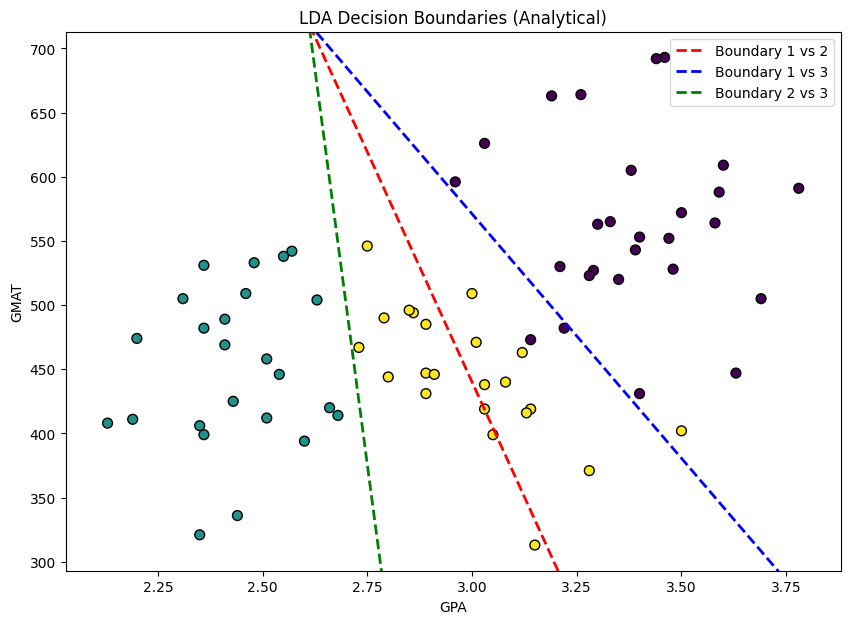

In [101]:
if VERBOSE:
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot the data points
    scatter = ax.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], 
                        c=y_train, cmap='viridis', edgecolors='k', s=50)

    # Get GPA range for plotting lines
    gpa_range = np.linspace(X_train.iloc[:, 0].min() - 0.1, 
                            X_train.iloc[:, 0].max() + 0.1, 100)

    # Plot decision boundary between each pair of classes
    classes = lda.classes_
    colors = ['red', 'blue', 'green']
    pairs = [(0, 1), (0, 2), (1, 2)]  # class index pairs

    for (i, j), color in zip(pairs, colors):
        # Coefficients for the boundary line
        coef_diff = lda.coef_[i] - lda.coef_[j]
        intercept_diff = lda.intercept_[i] - lda.intercept_[j]
        
        # Solve for GMAT: coef_diff[0]*GPA + coef_diff[1]*GMAT + intercept_diff = 0
        # GMAT = -(coef_diff[0]*GPA + intercept_diff) / coef_diff[1]
        gmat_boundary = -(coef_diff[0] * gpa_range + intercept_diff) / coef_diff[1]
        
        ax.plot(gpa_range, gmat_boundary, color=color, linestyle='--', linewidth=2,
                label=f'Boundary {classes[i]} vs {classes[j]}')

    ax.set_xlim(X_train.iloc[:, 0].min() - 0.1, X_train.iloc[:, 0].max() + 0.1)
    ax.set_ylim(X_train.iloc[:, 1].min() - 20, X_train.iloc[:, 1].max() + 20)
    ax.set_xlabel('GPA')
    ax.set_ylabel('GMAT')
    ax.set_title('LDA Decision Boundaries (Analytical)')
    ax.legend()
    plt.show()

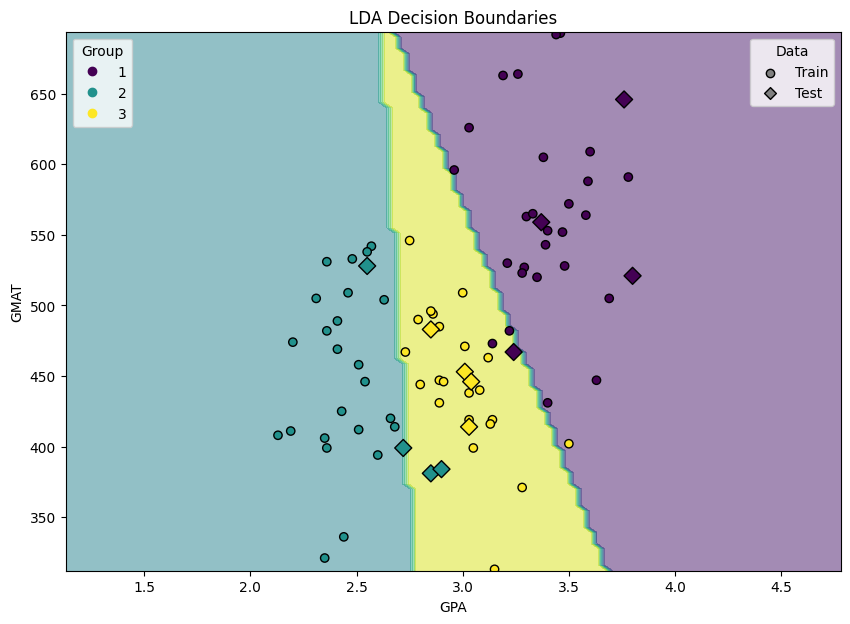

In [102]:
if VERBOSE:
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot decision boundaries (one line!)
    disp = DecisionBoundaryDisplay.from_estimator(
        lda, 
        X_train, 
        response_method="predict",
        alpha=0.5,
        ax=ax,
        xlabel='GPA',
        ylabel='GMAT'
    )

    # Overlay the actual data points
    scatter_train = ax.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], 
                        c=y_train, edgecolor="k", cmap='viridis')
    scatter_test = ax.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], 
                        c=y_test, edgecolor="k", cmap='viridis', marker='D', s=75)

    # Create invisible scatter points just for legend
    train_handle = ax.scatter([], [], marker='o', c='gray', edgecolor='k', label='Train')
    test_handle = ax.scatter([], [], marker='D', c='gray', edgecolor='k', label='Test')

    # Legend 1: Groups
    legend1 = ax.legend(*scatter_train.legend_elements(), title="Group", loc='upper left')
    ax.add_artist(legend1)

    # Legend 2: Markers
    ax.legend(handles=[train_handle, test_handle], title="Data", loc='upper right')

    ax.set_title('LDA Decision Boundaries')
    if SAVE_FIGS:
        plt.savefig('../images/HW_2/problem_2_lda_decision_boundaries.png', dpi=300)
    plt.show()

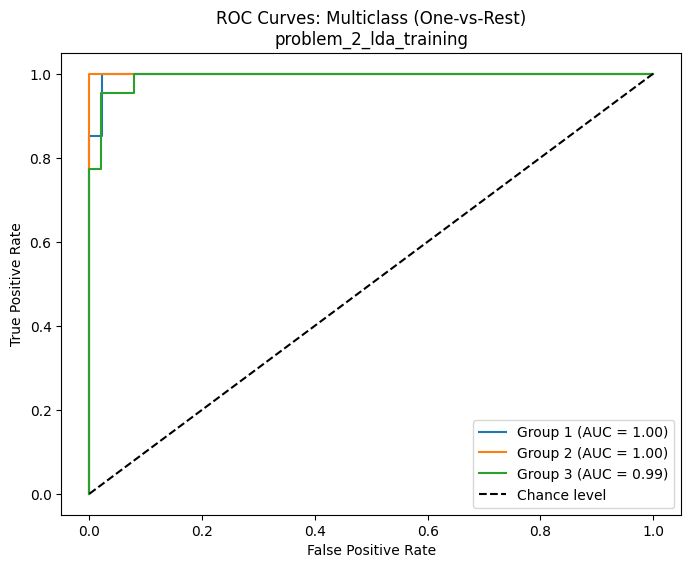

problem_2_lda_training train AUC (macro OVR): 0.9965497544355175


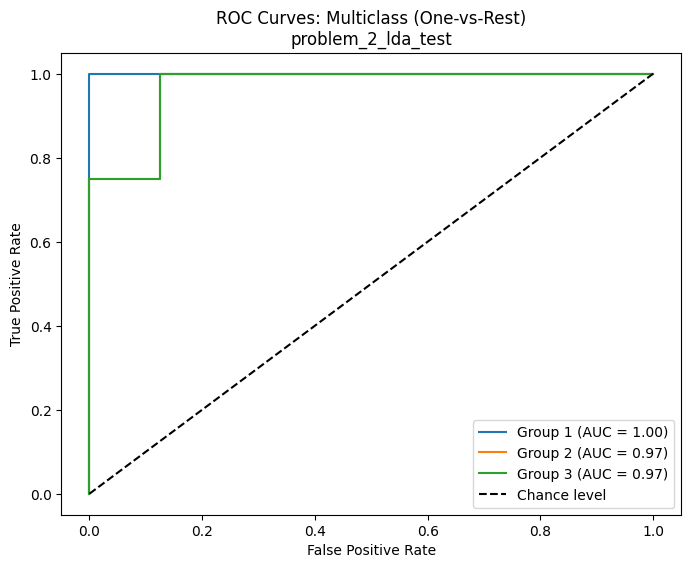

problem_2_lda_test train AUC (macro OVR): 0.9791666666666666


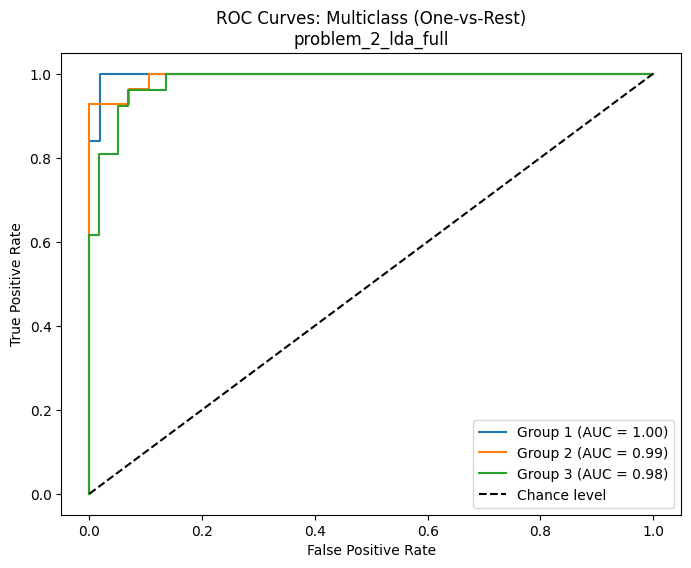

problem_2_lda_full train AUC (macro OVR): 0.991266108490553


In [103]:
# LDA ROC Curve and AUC
if VERBOSE:
    plot_roc_curve(lda, y_train, X_train, save_fig=False, save_name = "problem_2_lda_training")
    plot_roc_curve(lda, y_test, X_test, save_fig=False, save_name = "problem_2_lda_test")
    plot_roc_curve(lda, y, X, save_fig=False, save_name = "problem_2_lda_full")


<!-- Perform an QDA using the training data. Superimpose the decision boundary on an appropriate display of the data. Does the decision boundary seem sensible? In addition, compute the confusion matrix and overall misclassification rate based on both training and test data. What do you observe? -->

**c)** Repeat (b) using QDA.

In [104]:
# Apply Linear Discriminant Analysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred_test = qda.predict(X_test)
y_pred_train = qda.predict(X_train)

qda.classes_

if VERBOSE:
    display(HTML('<h3>Confusion Matrix for Training Data</h3>'))
    display(confusion_table(y_pred_train, y_train.values, lda.classes_))
    if PRINT_LATEX:
        print(confusion_table(y_pred_train, y_train.values, lda.classes_).to_latex())

    display(HTML('<h3>Confusion Matrix for Test Data</h3>'))
    display(confusion_table(y_pred_test, y_test.values, lda.classes_))
    if PRINT_LATEX:
        print(confusion_table(y_pred_test, y_test.values, lda.classes_).to_latex())

    cm_test = confusion_matrix(y_test, y_pred_test)
    cm_train = confusion_matrix(y_train, y_pred_train)
    # Misclassification rate = (Total Samples - Correct Predictions) / Total Samples
    misclass_rate_test = (cm_test.sum() - cm_test.diagonal().sum()) / cm_test.sum() 
    misclass_rate_train = (cm_train.sum() - cm_train.diagonal().sum()) / cm_train.sum() 
    misclass_rate_total = (cm_test.sum() - cm_test.diagonal().sum() + cm_train.sum() - cm_train.diagonal().sum()) / (cm_test.sum() + cm_train.sum())
    print(f"Misclassification rate for test data: {misclass_rate_test*100:.2f}%")
    print(f"Misclassification rate for train data: {misclass_rate_train*100:.2f}%")
    print(f"Misclassification rate for all data: {misclass_rate_total*100:.2f}%")


Truth,1,2,3
Predicted,,,
1,26,0,1
2,0,24,0
3,1,0,21


Truth,1,2,3
Predicted,,,
1,4,0,0
2,0,2,0
3,0,2,4


Misclassification rate for test data: 16.67%
Misclassification rate for train data: 2.74%
Misclassification rate for all data: 4.71%


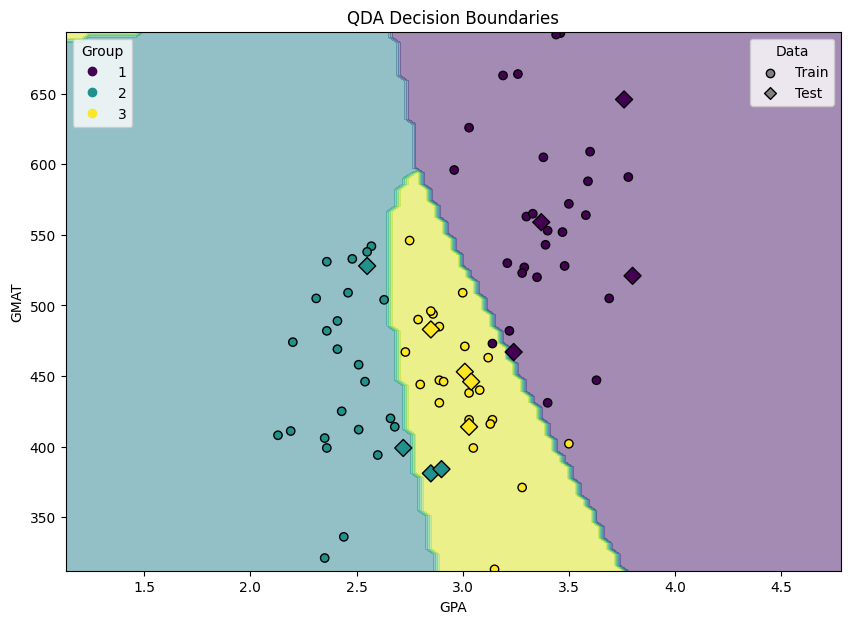

In [105]:
if VERBOSE:
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot decision boundaries (one line!)
    disp = DecisionBoundaryDisplay.from_estimator(
        qda, 
        X_train, 
        response_method="predict",
        alpha=0.5,
        ax=ax,
        xlabel='GPA',
        ylabel='GMAT'
    )

    # Overlay the actual data points
    scatter_train = ax.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], 
                        c=y_train, edgecolor="k", cmap='viridis')
    scatter_test = ax.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], 
                        c=y_test, edgecolor="k", cmap='viridis', marker='D', s=75)

    # Create invisible scatter points just for legend
    train_handle = ax.scatter([], [], marker='o', c='gray', edgecolor='k', label='Train')
    test_handle = ax.scatter([], [], marker='D', c='gray', edgecolor='k', label='Test')

    # Legend 1: Groups
    legend1 = ax.legend(*scatter_train.legend_elements(), title="Group", loc='upper left')
    ax.add_artist(legend1)

    # Legend 2: Markers
    ax.legend(handles=[train_handle, test_handle], title="Data", loc='upper right')

    ax.set_title('QDA Decision Boundaries')
    if SAVE_FIGS:
        plt.savefig('../images/HW_2/problem_2_qda_decision_boundaries.png', dpi=300)
    plt.show()

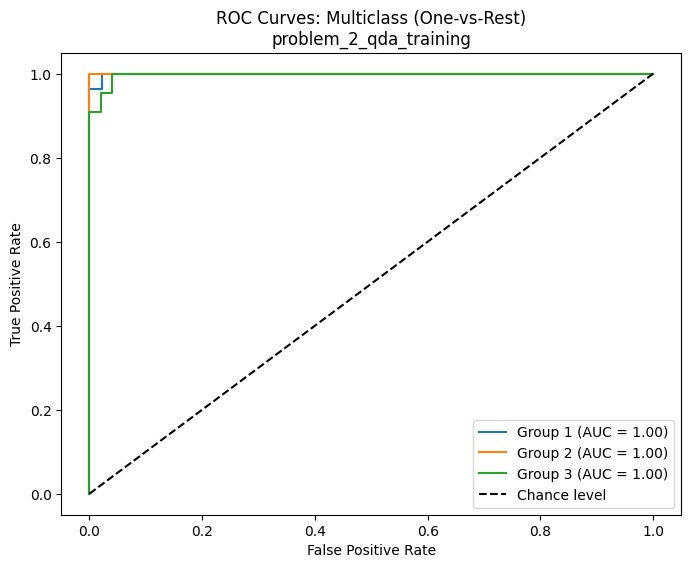

problem_2_qda_training train AUC (macro OVR): 0.9988403500764967


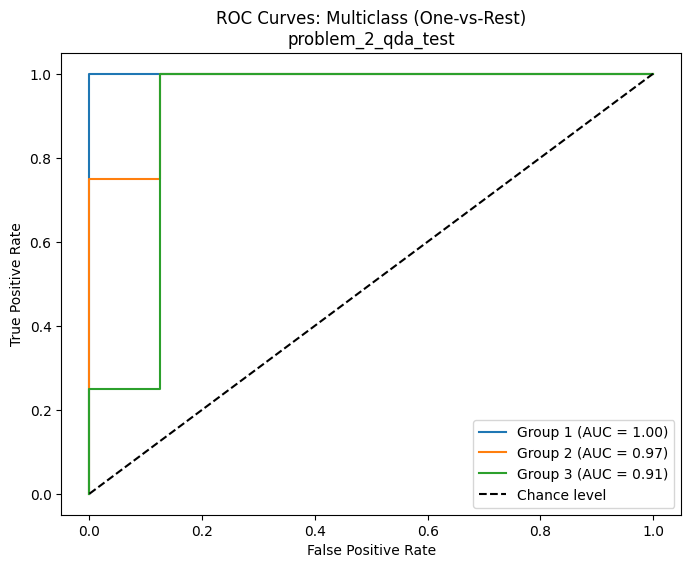

problem_2_qda_test train AUC (macro OVR): 0.9583333333333334


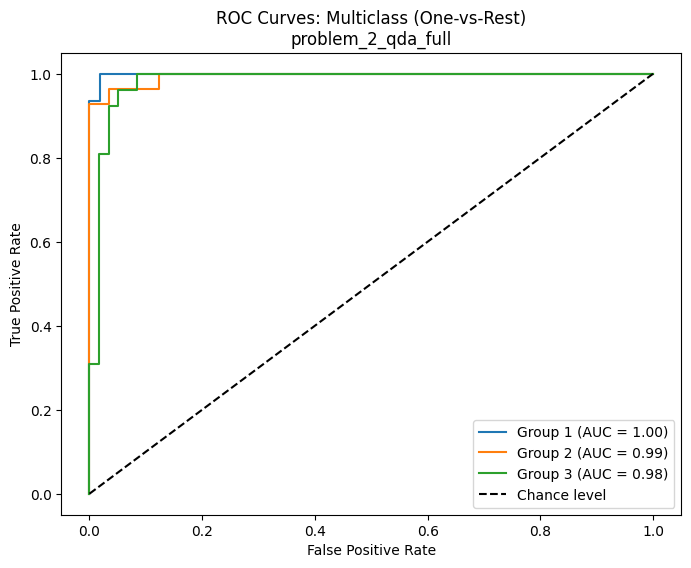

problem_2_qda_full train AUC (macro OVR): 0.9918550387002134


In [106]:
# QDA ROC Curve and AUC
if VERBOSE:
    plot_roc_curve(qda, y_train, X_train, save_fig=False, save_name = "problem_2_qda_training")
    plot_roc_curve(qda, y_test, X_test, save_fig=False, save_name = "problem_2_qda_test")
    plot_roc_curve(qda, y, X, save_fig=False, save_name = "problem_2_qda_full")

**d)** Fit a KNN with K chosen optimally using test error rate. Report error rate, sensitivity, specificity, and AUC for the optimal KNN based on the training data. Also, report its estimated test error rate.

</br>
</br>

**Error rate**: percentage misclassification
$$\frac{\text{Misclassified}}{\text{Total}} = 1 - \text{Accuracy}$$
**Sensitivity** (*true positive rate*): measures the proportion of actual positives correctly identified as positive 
$$\frac{\text{Number of true positives}}{\text{Number of true positives} + \text{Number of false negatives}}$$
**Specificity** (*true negative rate*): measures the proportion of actual negatives correctly identified. NOTE: Also called recall
$$\frac{\text{Number of true negatives}}{\text{Number of true negatives} + \text{Number of false positives}}$$

**Precision**: Ratio of the correctly predicted class to the total predicted class
$$\frac{\text{Number of true negatives}}{\text{Number of true positives} + \text{Number of false positives}}$$
**F1 Score**: A harmonic means between the Precision and Recall score
$$2 \times \frac{\text{Precision} \times \text{Specificity}}{\text{Precision} + \text{Specificity}}$$


ROC Curve: A Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system by plotting the true-positive rate (sensitivity) against the false-positive rate (1-specificity) across various decision thresholds $^{[1]}$. For a KNN classifier, the predicted probability for a class is the proportion of the K neighbors belonging to that class (i.e., $P(\text{class K}|x) = \frac{\text{number of neighbors in class}}{K}$). The ROC curve is generated by varying the probability threshold required to classify a point as positive. When building the ROC curve, we vary t, where $\text{t} \in [0, 1]$ with the decision rule being predict Class_n if $P(\text{Class\_n}|x) \geq t$

For a multiclass classification problem, we can no longer generate a single ROC curve since it is based ona binary classifier. We can use the one vs all scheme, which compares each class against all the others (assumed as one) [(scikit learn tutorial)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)



**NOTE**: Since KNN is a distance based method, we want to make sure that GMAT and GRE are on similar scales. We are going to use the standard scaling method from scikit learn on our training and test data.


[1] https://en.wikipedia.org/wiki/Receiver_operating_characteristic


Optimal K: 2


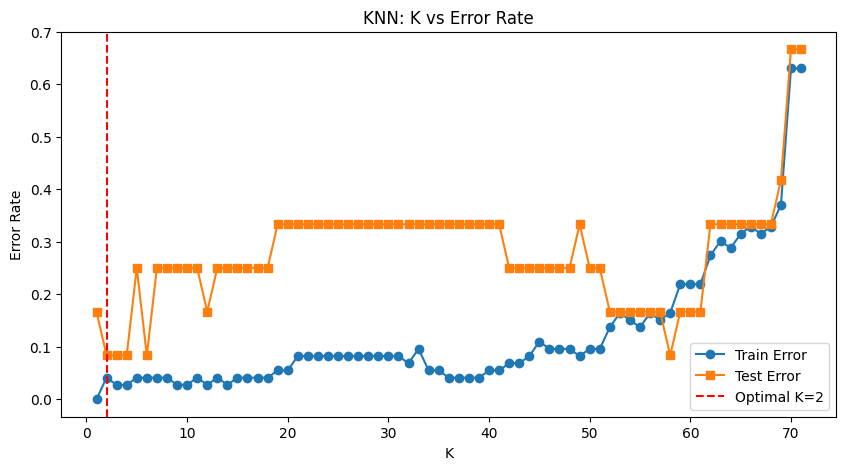


=== Training Data Metrics ===
Training Error Rate: 0.0411
Training Accuracy: 0.9589

Confusion Matrix (Train):
[[27  0  0]
 [ 0 24  0]
 [ 2  1 19]]

Per-Class Metrics (Training):
              precision    recall  f1-score   support

           1       0.93      1.00      0.96        27
           2       0.96      1.00      0.98        24
           3       1.00      0.86      0.93        22

    accuracy                           0.96        73
   macro avg       0.96      0.95      0.96        73
weighted avg       0.96      0.96      0.96        73



In [107]:
# Create a pipeline with scaler + KNN
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Optimal KNN Model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Test different K values to find optimal
k_range = range(1, len(X_train_scaled)-1)
train_errors = []
test_errors = []

for k in k_range:
    knn = knn_pipeline.set_params(knn__n_neighbors=k)
    # knn.fit(X_train_scaled, y_train)
    
    knn.fit(X_train, y_train)

    train_errors.append(1 - accuracy_score(y_train, knn_pipeline.predict(X_train)))
    test_errors.append(1 - accuracy_score(y_test, knn_pipeline.predict(X_test)))

# Find optimal K (lowest test error)
optimal_k = k_range[np.argmin(test_errors)]

if VERBOSE:
    print(f"Optimal K: {optimal_k}")

    # Plot K vs Error Rate
    plt.figure(figsize=(10, 5))
    plt.plot(k_range, train_errors, label='Train Error', marker='o')
    plt.plot(k_range, test_errors, label='Test Error', marker='s')
    plt.axvline(optimal_k, color='r', linestyle='--', label=f'Optimal K={optimal_k}')
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    plt.title('KNN: K vs Error Rate')
    plt.legend()

    if SAVE_FIGS:
        plt.savefig('../images/HW_2/problem_2_knn_k_vs_error_rate.png', dpi=300)
    plt.show()

# Fit optimal KNN
knn_opt = knn_pipeline.set_params(knn__n_neighbors=optimal_k)
knn_opt.fit(X_train, y_train)

y_train_pred = knn_opt.predict(X_train)
y_test_pred = knn_opt.predict(X_test)

if VERBOSE:
    # Metrics on TRAINING data
    print("\n=== Training Data Metrics ===")
    print(f"Training Error Rate: {1 - accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")

    # Confusion matrix for training
    cm_train = confusion_matrix(y_train, y_train_pred)
    print(f"\nConfusion Matrix (Train):\n{cm_train}")

    # Per-class sensitivity (recall) and specificity
    print("\nPer-Class Metrics (Training):")
    print(classification_report(y_train, y_train_pred))


Class 1: Sensitivity=1.0000, Specificity=0.9565
Class 2: Sensitivity=1.0000, Specificity=0.9796
Class 3: Sensitivity=0.8636, Specificity=1.0000

AUC (Training, OvR): 0.9986

=== Test Data Metrics ===
Test Error Rate: 0.0833
Test Accuracy: 0.9167

Confusion Matrix (Test):
[[4 0 0]
 [0 3 1]
 [0 0 4]]


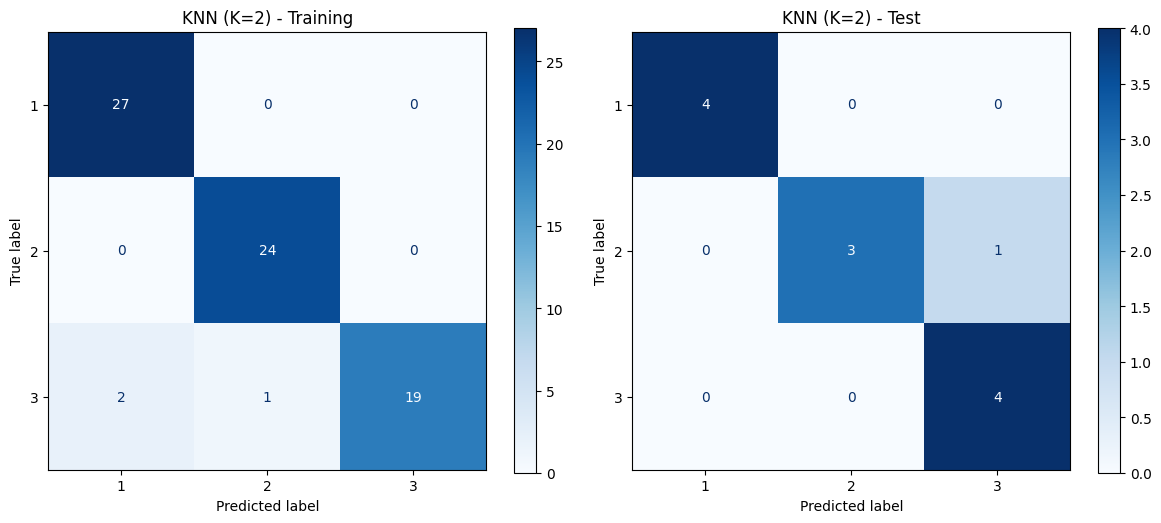

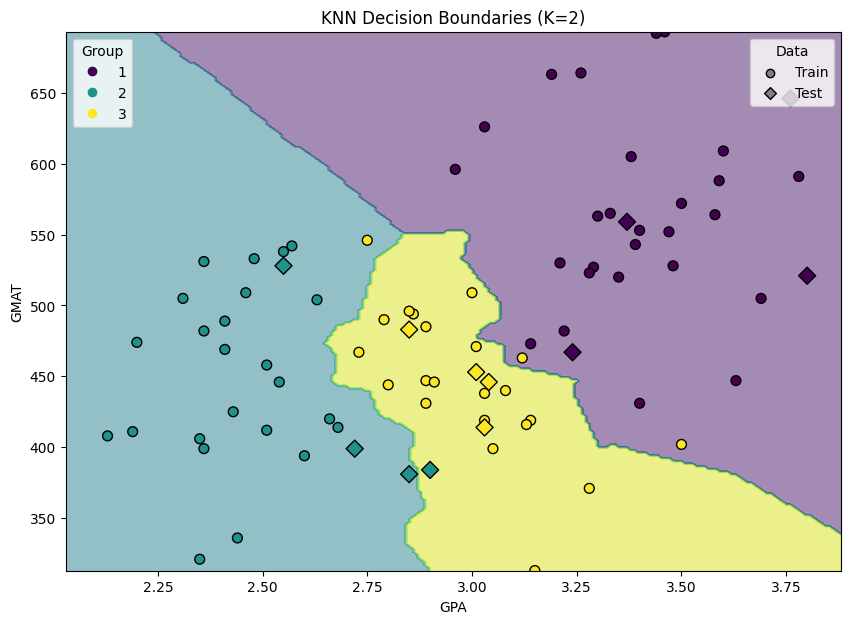

In [108]:
# Calculate sensitivity & specificity for each class (one-vs-rest)
classes = knn_opt.classes_
for i, _cls in enumerate(classes):
    sensitivity, specificity = calculate_metrics(_cls, y_train, y_train_pred)

    if VERBOSE:
        print(f"Class {_cls}: Sensitivity={sensitivity:.4f}, Specificity={specificity:.4f}")

# AUC (multiclass: one-vs-rest)
if hasattr(knn_opt, 'predict_proba'):
    y_train_proba = knn_opt.predict_proba(X_train)
    auc_train = roc_auc_score(y_train, y_train_proba, multi_class='ovr')

    if VERBOSE:
        print(f"\nAUC (Training, OvR): {auc_train:.4f}")

if VERBOSE:
    # Metrics on TEST data
    print("\n=== Test Data Metrics ===")
    print(f"Test Error Rate: {1 - accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

    cm_test = confusion_matrix(y_test, y_test_pred)
    print(f"\nConfusion Matrix (Test):\n{cm_test}")

    # Confusion matrix display
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ConfusionMatrixDisplay.from_estimator(knn_opt, X_train, y_train, ax=axes[0], cmap='Blues')
    axes[0].set_title(f'KNN (K={optimal_k}) - Training')
    ConfusionMatrixDisplay.from_estimator(knn_opt, X_test, y_test, ax=axes[1], cmap='Blues')
    axes[1].set_title(f'KNN (K={optimal_k}) - Test')
    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig('../images/HW_2/problem_2_knn_confusion_matrix.png', dpi=300)
    plt.show()

if VERBOSE:

    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot decision boundaries with HIGHER resolution for smoother appearance
    disp = DecisionBoundaryDisplay.from_estimator(
        knn_opt, 
        X_train, 
        response_method="predict",
        alpha=0.5,
        ax=ax,
        xlabel='GPA',
        ylabel='GMAT',
        grid_resolution=200,  # Increased from default 100 for smoother boundaries
        eps=0.1  # Slight padding
    )

    # Overlay the actual data points
    scatter_train = ax.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], 
                        c=y_train, edgecolor="k", cmap='viridis', s=50)
    scatter_test = ax.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], 
                        c=y_test, edgecolor="k", cmap='viridis', marker='D', s=75)

    # Create invisible scatter points just for legend
    train_handle = ax.scatter([], [], marker='o', c='gray', edgecolor='k', label='Train')
    test_handle = ax.scatter([], [], marker='D', c='gray', edgecolor='k', label='Test')

    # Legend 1: Groups
    legend1 = ax.legend(*scatter_train.legend_elements(), title="Group", loc='upper left')
    ax.add_artist(legend1)

    # Legend 2: Markers
    ax.legend(handles=[train_handle, test_handle], title="Data", loc='upper right')

    ax.set_title(f'KNN Decision Boundaries (K={optimal_k})')  # Fixed title
    if SAVE_FIGS:
        plt.savefig('../images/HW_2/problem_2_knn_decision_boundaries.png', dpi=300)
    plt.show()



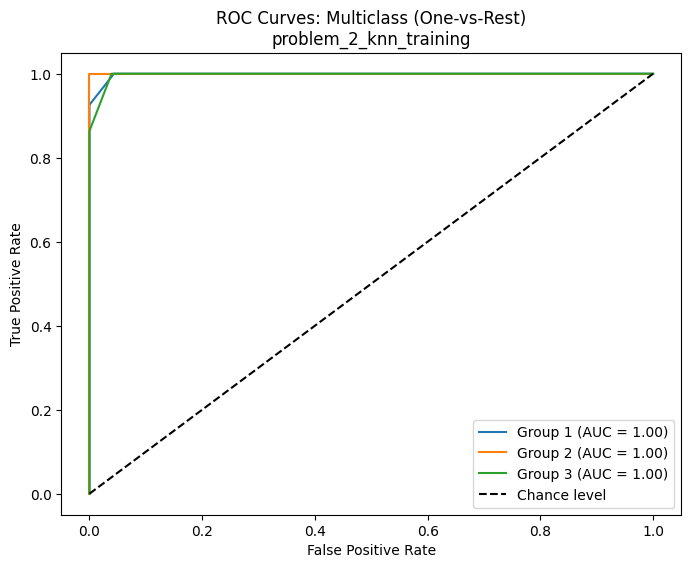

problem_2_knn_training train AUC (macro OVR): 0.9985719657501413


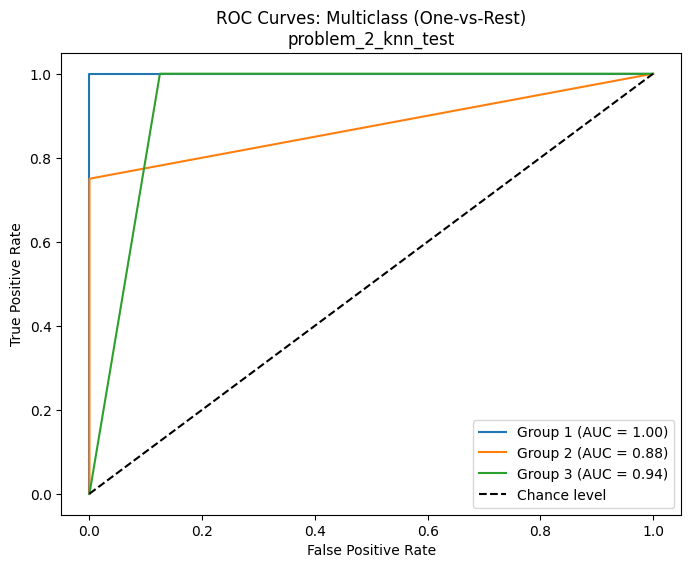

problem_2_knn_test train AUC (macro OVR): 0.9375


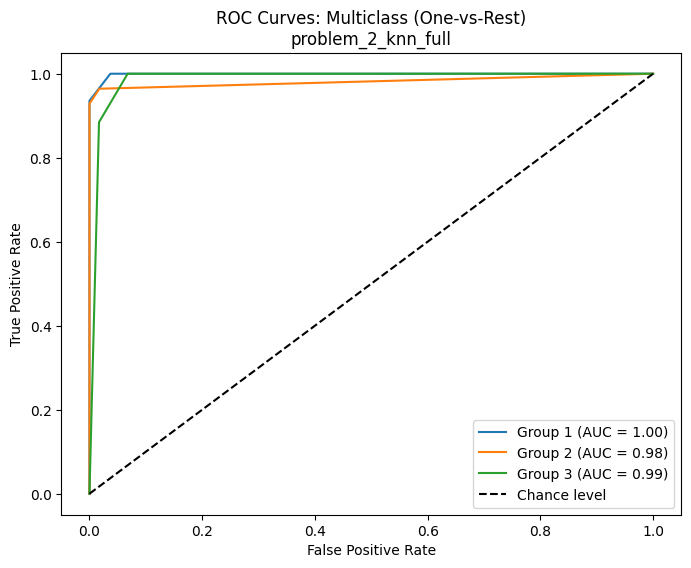

problem_2_knn_full train AUC (macro OVR): 0.98931187614367


In [109]:
if VERBOSE:
    plot_roc_curve(knn_opt, y_train, X_train, save_fig=SAVE_FIGS, save_name = "problem_2_knn_training")
    plot_roc_curve(knn_opt, y_test, X_test, save_fig=SAVE_FIGS, save_name = "problem_2_knn_test")
    plot_roc_curve(knn_opt, y, X, save_fig=SAVE_FIGS, save_name = "problem_2_knn_full")


**e)** Compare the results in (b), (c) and (d). Which classifier would you recommend? Justify your conclusions.

 We can see that the KNN classifier outperforms the other two classifiers, with the KNN having a misclassification rate for the test data of 8.3\% compared to 16.7\% and 25\% for QDA and LDA respectively. Given the lower test error rate and overall error rate, I would recommend the KNN classifier.